In [1]:
!date +%F

2024-11-14


### This script aims to perform GO term analysis, comparing SOX17 promoter and GRHL2 perturbation in all datasets

In [2]:
#!/usr/bin/env python3
import os
import re
import sys
import collections
import argparse
import tables
import glob
import itertools
import math

import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy.sparse as sp_sparse

import matplotlib.gridspec as gridspec
from multiprocessing import Pool
from collections import defaultdict
from scipy import sparse, io
from scipy.sparse import csr_matrix
from multiprocessing import Pool
import matplotlib.pyplot as plt
import gseapy as gp

In [3]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from matplotlib_venn import venn3

In [4]:
WTC11_PB9_DIR = '/project/GCRB/Hon_lab/s426305/Analysis/IGVF/20240605_WTC11_CMPilot2_PB9/pySpade/'
WTC11_lenti_DIR = '/project/GCRB/Hon_lab/s426305/Analysis/IGVF/20240611_WTC11_lenti_CMPilot2_reprocss/pySpade/'
H9_PB9_DIR = '/project/GCRB/Hon_lab/s426305/Analysis/IGVF/20240605_H9_CMPilot2_PB9/pySpade/'
H9_inducible_DIR = '/project/GCRB/Hon_lab/s426305/Analysis/IGVF/20240605_H9_CMPilot2_inducible/pySpade/'

### SOX17 promoter and GRHL2 promoter

In [5]:
SOX17_promoter = 'chr8:54457434-54458434'
GRHL2_promoter = 'chr8:101491939-101492939'

### GO term analysis, expressed genes as background

Processing WTC11_PB9
(5096, 18)
321
188
85


/project/GCRB/Hon_lab/s426305/Conda/py37-cluster2/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/project/GCRB/Hon_lab/s426305/Conda/py37-cluster2/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing H9_PB9
(20696, 18)
272
415
131


/project/GCRB/Hon_lab/s426305/Conda/py37-cluster2/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/project/GCRB/Hon_lab/s426305/Conda/py37-cluster2/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


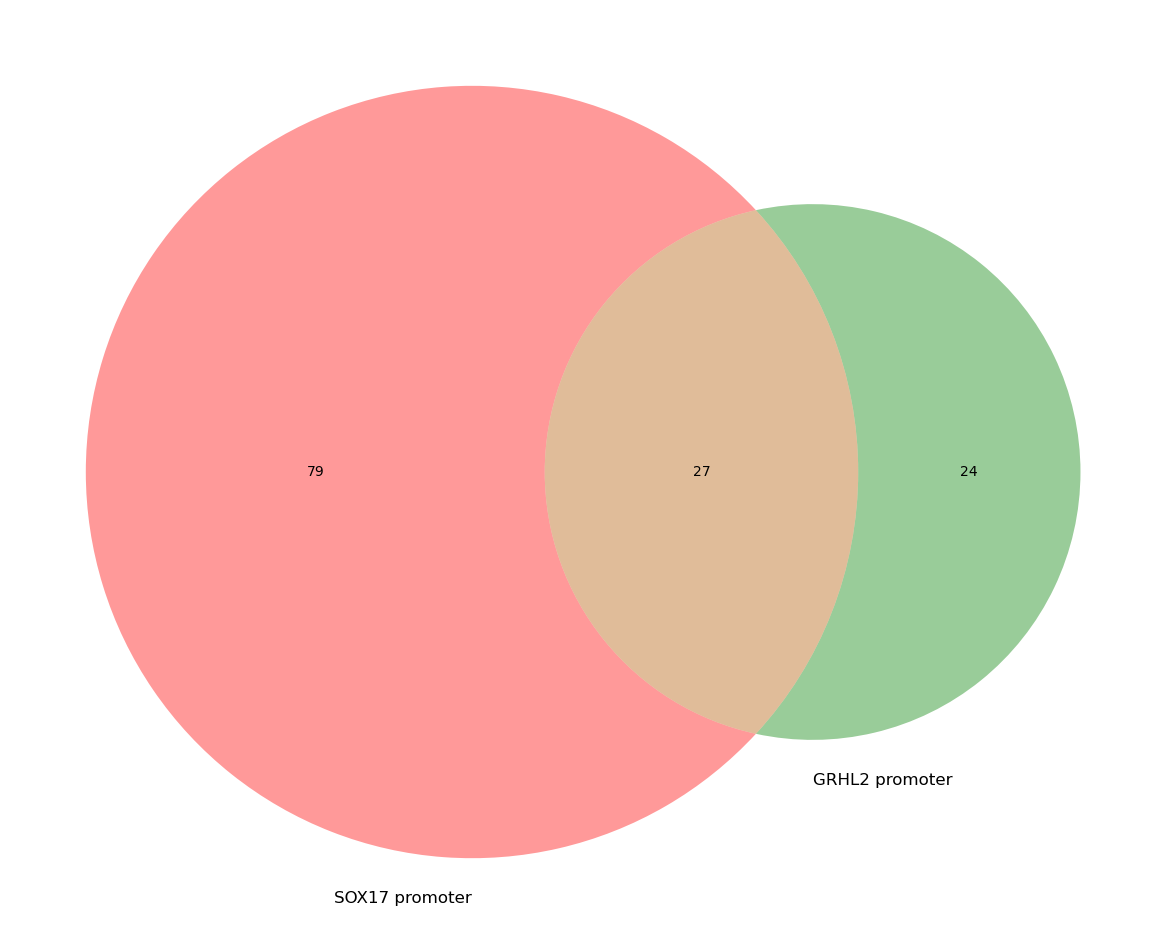

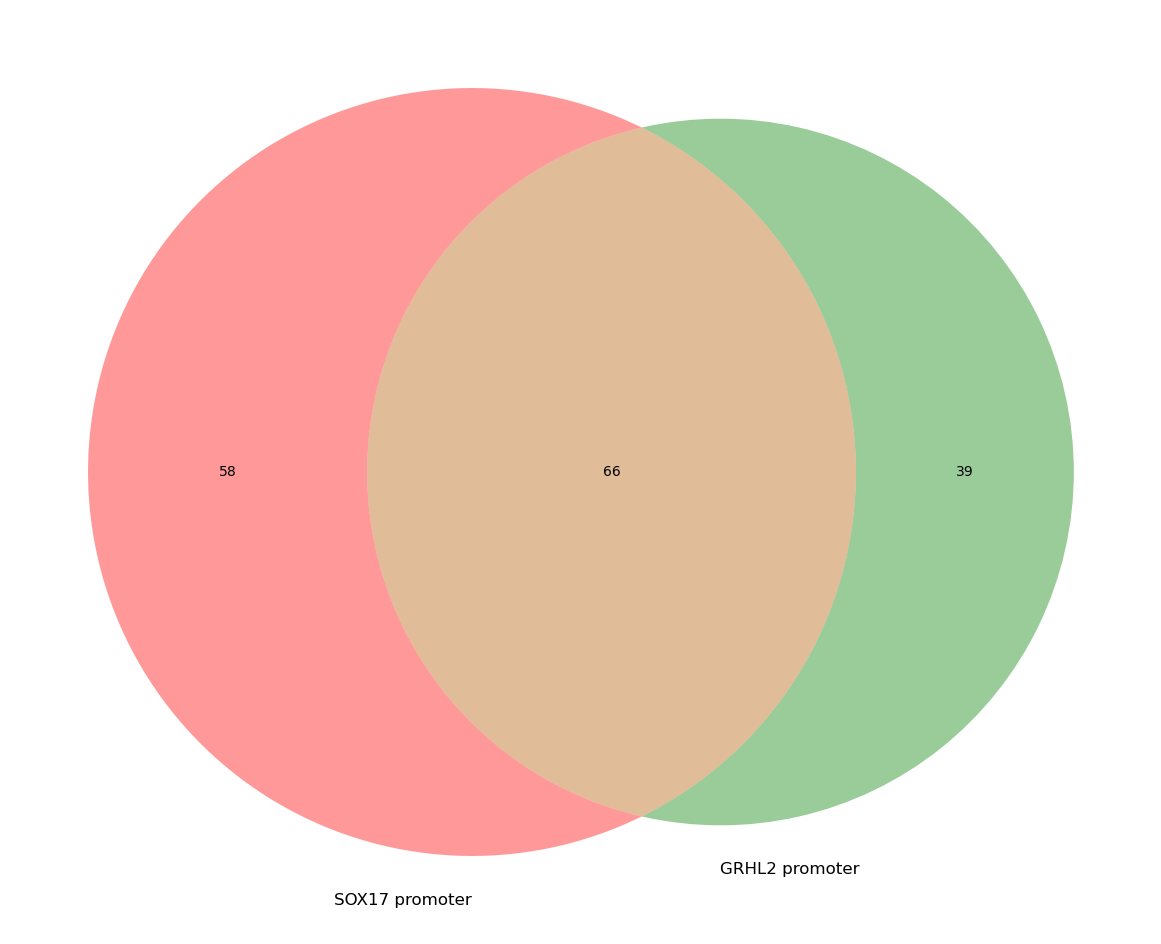

In [11]:
EXP = ['WTC11_PB9', 'H9_PB9']
DIR_list = [WTC11_PB9_DIR, H9_PB9_DIR]
for experiment in EXP:
    print('Processing ' + experiment)
    index = EXP.index(experiment)
    global_df = pd.read_csv(DIR_list[index] + 'Manhattan_plots/filtered_df.csv')
    print(global_df.shape)
    
    expression_cutoff = 0.05
    gene_seq = np.load(DIR_list[index] + 'Trans_genome_seq.npy', allow_pickle=True)
    express_level = np.load(DIR_list[index] + 'Perc_cell_expr.npy')
    express_idx = np.where(express_level > expression_cutoff)[0]
    express_gene = gene_seq[express_idx]
    
    SOX17_global = list(global_df[global_df['region'] == SOX17_promoter]['gene_names'])
    GRHL2_global = list(global_df[global_df['region'] == GRHL2_promoter]['gene_names'])
    print(len(SOX17_global))
    print(len(GRHL2_global))
    print(len(set(SOX17_global).intersection(set(GRHL2_global))))
    
    #GO term enrichment: SOX17
    enr = gp.enrichr(gene_list=SOX17_global,
                   gene_sets=['BioCarta_2016', 'KEGG_2021_Human', 'Reactome_2022', 'WikiPathways_2019_Human'], 
                   background=list(express_gene),
                   outdir=None,
                   cutoff=0.05)
    SOX17_pathway = enr.results[enr.results['Adjusted P-value'] < 0.05]
    SOX17_pathway['Pathway'] = SOX17_pathway['Gene_set'] + ':' + SOX17_pathway['Term']
    
    index_list = []
    value_list = []
    for i, j in enumerate(SOX17_pathway.sort_values(by='Adjusted P-value').head(20)['Adjusted P-value']):
        index_list.append(i)
        value_list.append(-np.log10(j))
    index_list.reverse()
    
    #GO term enrichment: GRHL2 promoter 
    enr = gp.enrichr(gene_list=GRHL2_global,
                   gene_sets=['BioCarta_2016', 'KEGG_2021_Human', 'Reactome_2022', 'WikiPathways_2019_Human'], 
                   background=list(express_gene),
                   outdir=None,
                   cutoff=0.05)
    GRHL2_pathway = enr.results[enr.results['Adjusted P-value'] < 0.05]
    GRHL2_pathway['Pathway'] = GRHL2_pathway['Gene_set'] + ':' + GRHL2_pathway['Term']
    
    index_list = []
    value_list = []
    for i, j in enumerate(GRHL2_pathway.sort_values(by='Adjusted P-value').head(20)['Adjusted P-value']):
        index_list.append(i)
        value_list.append(-np.log10(j))
    index_list.reverse()
    
    #Overlap
    fig = plt.figure(figsize=(16,12))
    set1 = set(SOX17_pathway['Pathway'])
    set2 = set(GRHL2_pathway['Pathway'])

    venn2([set1, set2], ('SOX17 promoter', 'GRHL2 promoter'))
    plt.savefig('3-3' + str(experiment) + '_SOX17_GRHL2_GO_overlap_20241114.pdf')

### NKX2-5, TBX5, TBX20

In [13]:
NKX25_promoter = 'chr5:173234812-173235812'
TBX5_promoter = 'chr12:114405644-114406644'
TBX20_promoter = 'chr7:35253600-35254600'

### GO term analysis, expressed genes as background

Processing WTC11_PB9
(5096, 18)
1203
51
1144
21


/project/GCRB/Hon_lab/s426305/Conda/py37-cluster2/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/project/GCRB/Hon_lab/s426305/Conda/py37-cluster2/lib/python3.7/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/project/GCRB/Hon_lab/s426305/Conda/py37-cluster2/lib/python3.7/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

Processing H9_PB9
(20696, 18)
1605
180
1152
15


/project/GCRB/Hon_lab/s426305/Conda/py37-cluster2/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/project/GCRB/Hon_lab/s426305/Conda/py37-cluster2/lib/python3.7/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/project/GCRB/Hon_lab/s426305/Conda/py37-cluster2/lib/python3.7/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

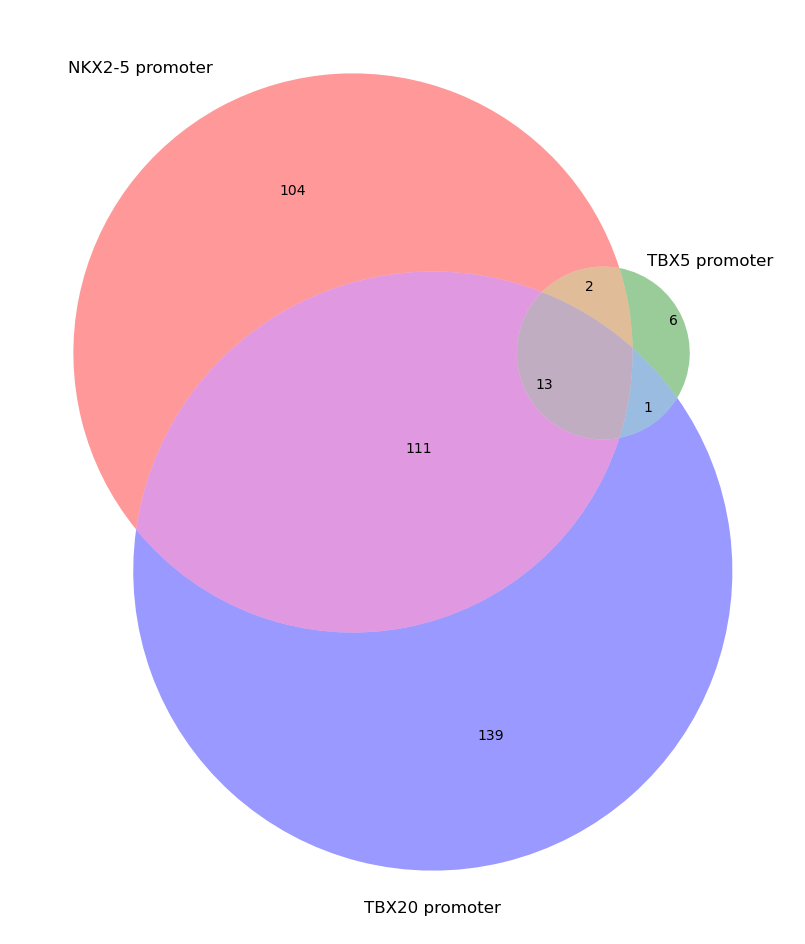

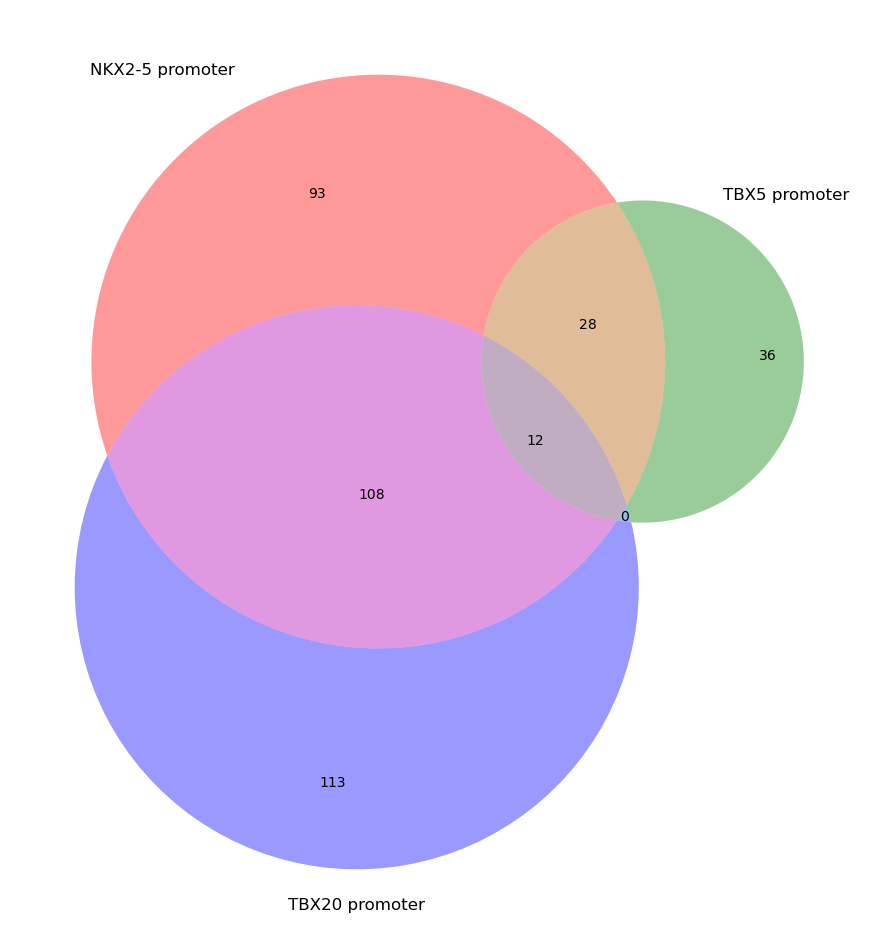

In [14]:
EXP = ['WTC11_PB9', 'H9_PB9']
DIR_list = [WTC11_PB9_DIR, H9_PB9_DIR]
for experiment in EXP:
    print('Processing ' + experiment)
    index = EXP.index(experiment)
    global_df = pd.read_csv(DIR_list[index] + 'Manhattan_plots/filtered_df.csv')
    print(global_df.shape)
    
    expression_cutoff = 0.05
    gene_seq = np.load(DIR_list[index] + 'Trans_genome_seq.npy', allow_pickle=True)
    express_level = np.load(DIR_list[index] + 'Perc_cell_expr.npy')
    express_idx = np.where(express_level > expression_cutoff)[0]
    express_gene = gene_seq[express_idx]
    
    NKX25_global = list(global_df[global_df['region'] == NKX25_promoter]['gene_names'])
    TBX5_global = list(global_df[global_df['region'] == TBX5_promoter]['gene_names'])
    TBX20_global = list(global_df[global_df['region'] == TBX20_promoter]['gene_names'])
    print(len(NKX25_global))
    print(len(TBX5_global))
    print(len(TBX20_global))
    print(len(set(NKX25_global).intersection(set(TBX5_global).intersection(set(TBX20_global)))))
    
    #GO term enrichment
    enr = gp.enrichr(gene_list=NKX25_global,
                   gene_sets=['BioCarta_2016', 'KEGG_2021_Human', 'Reactome_2022', 'WikiPathways_2019_Human'], 
                   background=list(express_gene),
                   outdir=None,
                   cutoff=0.05)
    NKX25_pathway = enr.results[enr.results['Adjusted P-value'] < 0.05]
    NKX25_pathway['Pathway'] = NKX25_pathway['Gene_set'] + ':' + NKX25_pathway['Term']
    
        
    #GO term enrichment
    enr = gp.enrichr(gene_list=TBX5_global,
                   gene_sets=['BioCarta_2016', 'KEGG_2021_Human', 'Reactome_2022', 'WikiPathways_2019_Human'], 
                   background=list(express_gene),
                   outdir=None,
                   cutoff=0.05)
    TBX5_pathway = enr.results[enr.results['Adjusted P-value'] < 0.05]
    TBX5_pathway['Pathway'] = TBX5_pathway['Gene_set'] + ':' + TBX5_pathway['Term']
    
    #GO term enrichment
    enr = gp.enrichr(gene_list=TBX20_global,
                   gene_sets=['BioCarta_2016', 'KEGG_2021_Human', 'Reactome_2022', 'WikiPathways_2019_Human'], 
                   background=list(express_gene),
                   outdir=None,
                   cutoff=0.05)
    TBX20_pathway = enr.results[enr.results['Adjusted P-value'] < 0.05]
    TBX20_pathway['Pathway'] = TBX20_pathway['Gene_set'] + ':' + TBX20_pathway['Term']
    
    #Overlap
    fig = plt.figure(figsize=(16,12))
    set1 = set(NKX25_pathway['Pathway'])
    set2 = set(TBX5_pathway['Pathway'])
    set3 = set(TBX20_pathway['Pathway'])
    
    venn3([set1, set2, set3], ('NKX2-5 promoter', 'TBX5 promoter', 'TBX20 promoter'))
    #plt.show()
    plt.savefig('3-3' + str(experiment) + '_NKX25_TBX5_TBX20_GO_overlap_20241114.pdf')

### TBX5 promoter and enhancer

In [16]:
NKX25_promoter = 'SG_TBX5-P2'
TBX5_promoter = 'TBXENH2'
TBX20_promoter = 'TBXENH3'

### GO term analysis, expressed genes as background

Processing WTC11_PB9
(5096, 18)
60
77
147
29


/project/GCRB/Hon_lab/s426305/Conda/py37-cluster2/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/project/GCRB/Hon_lab/s426305/Conda/py37-cluster2/lib/python3.7/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/project/GCRB/Hon_lab/s426305/Conda/py37-cluster2/lib/python3.7/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

Processing H9_PB9
(20696, 18)
98
237
307
30


/project/GCRB/Hon_lab/s426305/Conda/py37-cluster2/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/project/GCRB/Hon_lab/s426305/Conda/py37-cluster2/lib/python3.7/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/project/GCRB/Hon_lab/s426305/Conda/py37-cluster2/lib/python3.7/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

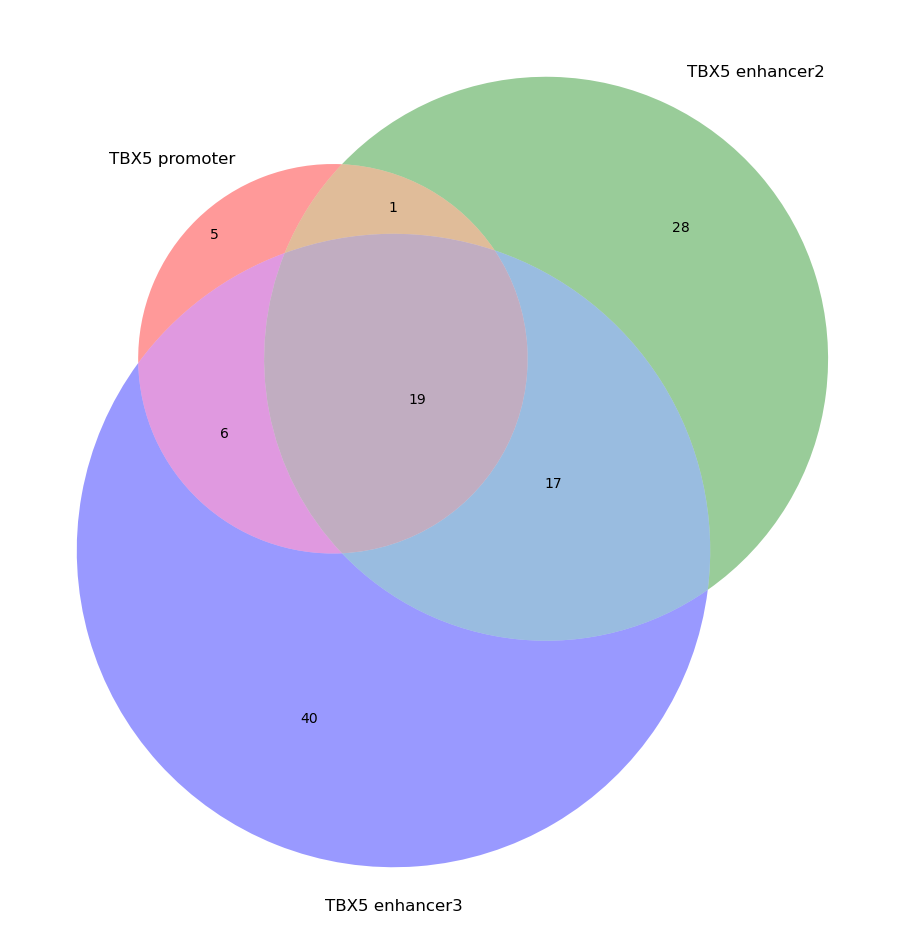

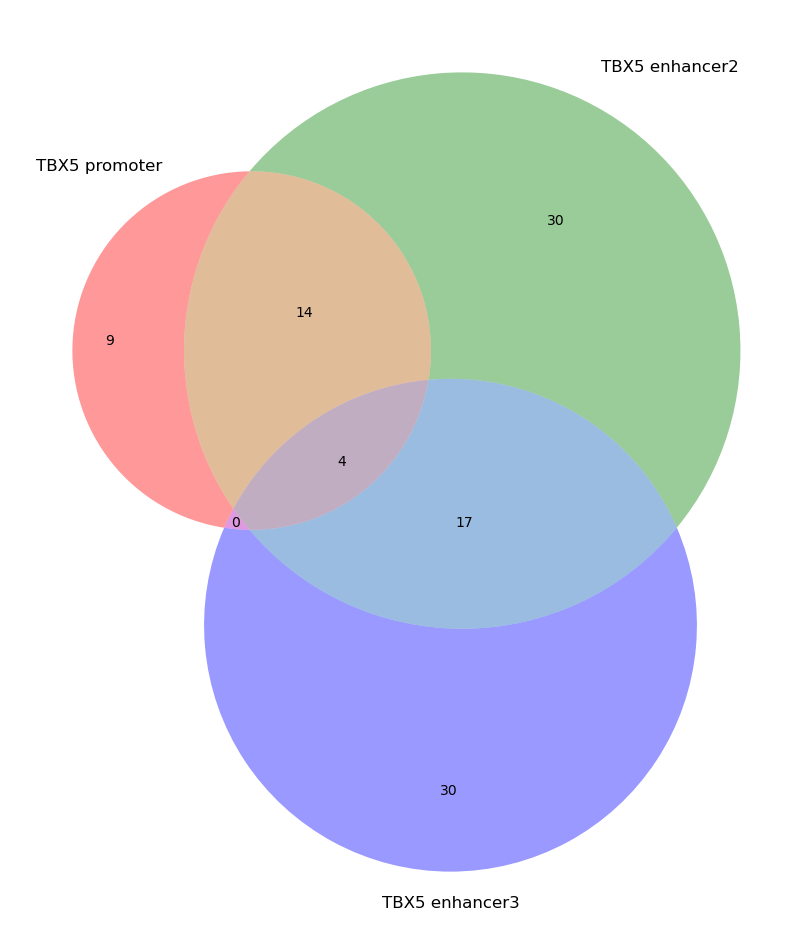

In [17]:
EXP = ['WTC11_PB9', 'H9_PB9']
DIR_list = [WTC11_PB9_DIR, H9_PB9_DIR]
for experiment in EXP:
    print('Processing ' + experiment)
    index = EXP.index(experiment)
    global_df = pd.read_csv(DIR_list[index] + 'Manhattan_plots/filtered_df.csv')
    print(global_df.shape)
    
    expression_cutoff = 0.05
    gene_seq = np.load(DIR_list[index] + 'Trans_genome_seq.npy', allow_pickle=True)
    express_level = np.load(DIR_list[index] + 'Perc_cell_expr.npy')
    express_idx = np.where(express_level > expression_cutoff)[0]
    express_gene = gene_seq[express_idx]
    
    NKX25_global = list(global_df[global_df['region'] == NKX25_promoter]['gene_names'])
    TBX5_global = list(global_df[global_df['region'] == TBX5_promoter]['gene_names'])
    TBX20_global = list(global_df[global_df['region'] == TBX20_promoter]['gene_names'])
    print(len(NKX25_global))
    print(len(TBX5_global))
    print(len(TBX20_global))
    print(len(set(NKX25_global).intersection(set(TBX5_global).intersection(set(TBX20_global)))))
    
    #GO term enrichment
    enr = gp.enrichr(gene_list=NKX25_global,
                   gene_sets=['BioCarta_2016', 'KEGG_2021_Human', 'Reactome_2022', 'WikiPathways_2019_Human'], 
                   background=list(express_gene),
                   outdir=None,
                   cutoff=0.05)
    NKX25_pathway = enr.results[enr.results['Adjusted P-value'] < 0.05]
    NKX25_pathway['Pathway'] = NKX25_pathway['Gene_set'] + ':' + NKX25_pathway['Term']
    
        
    #GO term enrichment
    enr = gp.enrichr(gene_list=TBX5_global,
                   gene_sets=['BioCarta_2016', 'KEGG_2021_Human', 'Reactome_2022', 'WikiPathways_2019_Human'], 
                   background=list(express_gene),
                   outdir=None,
                   cutoff=0.05)
    TBX5_pathway = enr.results[enr.results['Adjusted P-value'] < 0.05]
    TBX5_pathway['Pathway'] = TBX5_pathway['Gene_set'] + ':' + TBX5_pathway['Term']
    
    #GO term enrichment
    enr = gp.enrichr(gene_list=TBX20_global,
                   gene_sets=['BioCarta_2016', 'KEGG_2021_Human', 'Reactome_2022', 'WikiPathways_2019_Human'], 
                   background=list(express_gene),
                   outdir=None,
                   cutoff=0.05)
    TBX20_pathway = enr.results[enr.results['Adjusted P-value'] < 0.05]
    TBX20_pathway['Pathway'] = TBX20_pathway['Gene_set'] + ':' + TBX20_pathway['Term']
    
    #Overlap
    fig = plt.figure(figsize=(16,12))
    set1 = set(NKX25_pathway['Pathway'])
    set2 = set(TBX5_pathway['Pathway'])
    set3 = set(TBX20_pathway['Pathway'])
    
    venn3([set1, set2, set3], ('TBX5 promoter', 'TBX5 enhancer2', 'TBX5 enhancer3'))
#    plt.show()
    plt.savefig('3-3' + str(experiment) + '_TBX5_pro_enh_GO_overlap_20241114.pdf')